In [8]:
import os
import pandas as pd
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from utils.utils import *
from utils.dataset import XRayDataset

# CUDA

In [9]:
def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset and Dataloader

In [10]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_val = pd.read_csv('data/val.csv')

transform = T.Compose([
    T.Resize(256),
    T.ToTensor(),
])

train_dataset = XRayDataset(df_train, transform)
test_dataset = XRayDataset(df_test, transform)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=521, shuffle=True)

# Model

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(5, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(1296, 32)
        self.dropout1 = nn.Dropout(0.7)
        self.fc2 = nn.Linear(32, 16)
        self.dropout2 = nn.Dropout(0.7)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [12]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2, min_lr=0.000001)

In [13]:
def train(dataloader):
    model.train()
    c=0
    correct=0
    total = 0
    acc = 0

    for i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        c=c+1
        correct+=loss.cpu().detach().numpy()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        acc += (predicted == labels).sum().item()
        
    return correct/c, acc/total

def test(dataloader):
    model.eval()
    c=0
    correct=0
    total = 0
    acc = 0

    for i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        c=c+1
        correct+=loss.cpu().detach().numpy()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        acc += (predicted == labels).sum().item()
    return correct/c, acc/total

In [14]:
train_matrix = {'loss':[], 'accuracy':[]}
test_matrix = {'loss':[], 'accuracy':[]}
epochs = 25
min_loss = 100
print('start train\n')

for epoch in range(epochs):
    train_loss, train_acc = train(train_dataloader)
    test_loss, test_acc = test(test_dataloader)
    train_matrix['loss'].append(train_loss)
    train_matrix['accuracy'].append(train_acc)
    test_matrix['loss'].append(test_loss)
    test_matrix['accuracy'].append(test_acc)
    scheduler.step(test_loss)
    print(f'Epoch: {epoch+1:03d}, Train CrossEntropy: {train_loss:.4f}, Test CrossEntropy: {test_loss:.4f}')
    print(f'            Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}\n')

start train

Epoch: 001, Train CrossEntropy: 0.6138, Test CrossEntropy: 0.6478
            Train Accuracy: 0.7402, Test Accuracy: 0.6250

Epoch: 002, Train CrossEntropy: 0.5940, Test CrossEntropy: 0.6608
            Train Accuracy: 0.7429, Test Accuracy: 0.6250

Epoch: 003, Train CrossEntropy: 0.5769, Test CrossEntropy: 0.6291
            Train Accuracy: 0.7429, Test Accuracy: 0.6250

Epoch: 004, Train CrossEntropy: 0.5390, Test CrossEntropy: 0.6071
            Train Accuracy: 0.7429, Test Accuracy: 0.6250

Epoch: 005, Train CrossEntropy: 0.4956, Test CrossEntropy: 0.5691
            Train Accuracy: 0.7429, Test Accuracy: 0.6250

Epoch: 006, Train CrossEntropy: 0.4558, Test CrossEntropy: 0.5719
            Train Accuracy: 0.7429, Test Accuracy: 0.6250

Epoch: 007, Train CrossEntropy: 0.4285, Test CrossEntropy: 0.5498
            Train Accuracy: 0.7429, Test Accuracy: 0.6250

Epoch: 008, Train CrossEntropy: 0.4171, Test CrossEntropy: 0.5154
            Train Accuracy: 0.7429, Test Accur

In [19]:
# torch.save(model.state_dict(), 'model/ver1/last.pt')

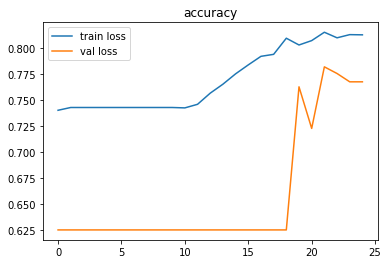

In [15]:
plt.title('accuracy')
plt.plot(np.arange(epochs), train_matrix['accuracy'], label='train loss')
plt.plot(np.arange(epochs), test_matrix['accuracy'], label='val loss')

plt.legend()
plt.show()

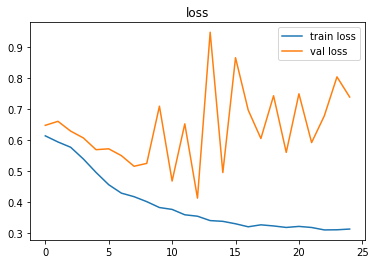

In [16]:
plt.title('loss')
plt.plot(np.arange(epochs), train_matrix['loss'], label='train loss')
plt.plot(np.arange(epochs), test_matrix['loss'], label='val loss')

plt.legend()
plt.show()

In [17]:
for i, data in enumerate(test_dataloader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data[0].to(device), data[1].to(device)

    # forward + backward + optimize
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
#     break

In [55]:
predicted

tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')